<a href="https://colab.research.google.com/github/eyupdalan/BLM6114-project-v2/blob/main/BLM6114_project_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q datasets pandas torch transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 113.6 MB/s eta 0:00:00


In [2]:
import pandas as pd

ds_question_types = pd.read_csv('gsm8k_tr_classified_merged.csv')
ds_question_types.head()

,question,answer,question_type,solution_method,question_type_old,solution_method_old,tr_llama_result,is_tr_llama_correct,gg_gemma_result,is_gg_gemma_correct
0,Borris tekel bayisi her 6 ayda bir 90 kilogram...,Borris şu anda her 6 ayda 90 kilogram üzüm kul...,"{""type"": ""Oran orantı problemi"", ""explanation""...","{""method"": ""proportional calculation"", ""explan...",oran-orantı,yüzde hesaplama,Sonuç: 108000,0.0,Sonuç: 270 \n,0.0
1,"Mel, Katherine'den üç yaş küçük. Katherine ik...",Katherine iki düzine yaşına geldiğinde 24 yaşı...,"{""type"": ""Aritmetik Problem"", ""explanation"": ""...","{""method"": ""Aritmetik Hesaplama"", ""explanation...",yaş problemi,doğrudan çıkarma,Sonuç: 20,0.0,Sonuç: 21 \n,1.0
2,James 2 ağacındaki tüm meyveleri toplar. Her ...,James 24 ağaç dikmiştir.,"{""type"": ""problem solving"", ""explanation"": ""Bu...","{""method"": ""beyin fırtınası"", ""explanation"": ""...",oran-orantı,birim oran,Sonuç: 8,0.0,Sonuç: 24 \n,1.0
3,"Kyle, her biri 15 origami yıldızı alabilen 2 c...",Kyle toplamda 5 cam şişe satın aldı (2 + 3). H...,"{""type"": ""Arithmetic Problem"", ""explanation"": ...","{""method"": ""Çarpma ve Toplama"", ""explanation"":...",çarpma,doğrudan çarpma,Sonuç: 360,0.0,Sonuç: 90 \n,0.0
4,Mark'ın iki evcil hayvanı var: Saniyede 10 adı...,Kaplumbağanın yarışı berabere bitirmesi için 1...,"{""type"": ""Hız/Zaman Problemleri"", ""explanation...","{""method"": ""hesaplama"", ""explanation"": ""Kaplum...",oran-orantı,birim oran,Sonuç: 18,1.0,Sonuç: 18 \n,1.0


# Embedding işlemleri

In [27]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel

df = pd.read_csv("gsm8k_tr_classified_merged.csv")
print("Veri seti okundu:")
print(df.head())

device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("ytu-ce-cosmos/turkish-e5-large")
model     = AutoModel.from_pretrained("ytu-ce-cosmos/turkish-e5-large").to(device)

def embed_texts(texts, batch_size=16):
  all_embs = []
  for i in range(0, len(texts), batch_size):
    batch = texts[i : i+batch_size]
    enc = tokenizer(batch, padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
      last_hidden = model(**enc).last_hidden_state  # (B, L, D)
      emb = last_hidden.mean(dim=1)                 # mean pooling → (B, D)
    all_embs.append(emb.cpu())
  return torch.cat(all_embs, dim=0).numpy()

for col in ["question", "answer", "question_type", "solution_method"]:
  print(f"Embedding yapılıyor: {col}")
  embs = embed_texts(df[col].astype(str).tolist(), batch_size=16)
  df[f"{col}_emb"] = list(embs) # embedding'i sonuna "_emb" eklenerek yeni kolon olarak ekleniyor.
  print(f"Embedding tamamlandı: {col}")

df.to_pickle("gsm8k_tr_with_embeddings.pkl")

Veri seti okundu:
                                            question  \
0  Borris tekel bayisi her 6 ayda bir 90 kilogram...   
1  Mel, Katherine'den üç yaş küçük.  Katherine ik...   
2  James 2 ağacındaki tüm meyveleri toplar.  Her ...   
3  Kyle, her biri 15 origami yıldızı alabilen 2 c...   
4  Mark'ın iki evcil hayvanı var: Saniyede 10 adı...   

                                              answer  \
0  Borris şu anda her 6 ayda 90 kilogram üzüm kul...   
1  Katherine iki düzine yaşına geldiğinde 24 yaşı...   
2                           James 24 ağaç dikmiştir.   
3  Kyle toplamda 5 cam şişe satın aldı (2 + 3). H...   
4  Kaplumbağanın yarışı berabere bitirmesi için 1...   

                                       question_type  \
0  {"type": "Oran orantı problemi", "explanation"...   
1  {"type": "Aritmetik Problem", "explanation": "...   
2  {"type": "problem solving", "explanation": "Bu...   
3  {"type": "Arithmetic Problem", "explanation": ...   
4  {"type": "Hız/Zaman Probl

In [29]:
import pandas as pd

try:
    df_embeddings = pd.read_pickle("gsm8k_tr_with_embeddings.pkl")
    print("Embedding dosyası başarıyla yüklendi.")
    print("\nEmbedding içeren veri çerçevesinin ilk 5 satırı:")
    display(df_embeddings.head())
except FileNotFoundError:
    print("Hata: 'gsm8k_tr_with_embeddings.csv' dosyası bulunamadı.")
    print("Lütfen dosyanın doğru yolda olduğundan emin olun.")

Embedding dosyası başarıyla yüklendi.

Embedding içeren veri çerçevesinin ilk 5 satırı:


,question,answer,question_type,solution_method,question_type_old,solution_method_old,tr_llama_result,is_tr_llama_correct,gg_gemma_result,is_gg_gemma_correct,question_emb,answer_emb,question_type_emb,solution_method_emb
0,Borris tekel bayisi her 6 ayda bir 90 kilogram...,Borris şu anda her 6 ayda 90 kilogram üzüm kul...,"{""type"": ""Oran orantı problemi"", ""explanation""...","{""method"": ""proportional calculation"", ""explan...",oran-orantı,yüzde hesaplama,Sonuç: 108000,0.0,Sonuç: 270 \n,0.0,"[0.6715006, 1.0025988, -0.8141864, -0.15699771...","[0.5446431, 1.1449226, -0.8158145, 0.37072867,...","[0.1897387, 0.12631406, -0.6594379, -0.1644133...","[-0.08096628, 0.57343423, -0.24044694, -0.1566..."
1,"Mel, Katherine'den üç yaş küçük. Katherine ik...",Katherine iki düzine yaşına geldiğinde 24 yaşı...,"{""type"": ""Aritmetik Problem"", ""explanation"": ""...","{""method"": ""Aritmetik Hesaplama"", ""explanation...",yaş problemi,doğrudan çıkarma,Sonuç: 20,0.0,Sonuç: 21 \n,1.0,"[0.52484596, -0.20660642, -0.56891537, -0.7240...","[0.8434993, 0.19339159, -0.5099972, -0.523887,...","[1.430924, -0.630825, -1.0841881, -0.45744488,...","[1.091192, -0.30429524, -0.9432773, -0.4693212..."
2,James 2 ağacındaki tüm meyveleri toplar. Her ...,James 24 ağaç dikmiştir.,"{""type"": ""problem solving"", ""explanation"": ""Bu...","{""method"": ""beyin fırtınası"", ""explanation"": ""...",oran-orantı,birim oran,Sonuç: 8,0.0,Sonuç: 24 \n,1.0,"[0.10532897, -0.35827264, -1.2728502, -0.37101...","[0.27943563, 0.28232127, -0.38983282, -0.13706...","[0.19272597, -0.4171816, -1.2453085, -0.172306...","[0.91966903, -0.8279106, -0.5111354, -1.107286..."
3,"Kyle, her biri 15 origami yıldızı alabilen 2 c...",Kyle toplamda 5 cam şişe satın aldı (2 + 3). H...,"{""type"": ""Arithmetic Problem"", ""explanation"": ...","{""method"": ""Çarpma ve Toplama"", ""explanation"":...",çarpma,doğrudan çarpma,Sonuç: 360,0.0,Sonuç: 90 \n,0.0,"[-0.57047623, 0.49581084, -0.5631299, -0.70389...","[-0.59139633, 0.22431299, -0.14734289, -0.2561...","[0.324803, 0.66421705, -0.27458137, -0.4329316...","[0.35767016, 0.50170404, -0.4520758, -0.193654..."
4,Mark'ın iki evcil hayvanı var: Saniyede 10 adı...,Kaplumbağanın yarışı berabere bitirmesi için 1...,"{""type"": ""Hız/Zaman Problemleri"", ""explanation...","{""method"": ""hesaplama"", ""explanation"": ""Kaplum...",oran-orantı,birim oran,Sonuç: 18,1.0,Sonuç: 18 \n,1.0,"[0.30706674, 0.041912753, -1.2288647, -0.58014...","[-0.03708125, 0.080958925, 0.4905705, -0.78892...","[0.49798334, -0.5233716, -0.4075574, -0.408287...","[0.6446417, -0.42181966, -0.809587, -0.5064804..."


## Lojistik Regresyon

In [31]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

df = pd.read_pickle("gsm8k_tr_with_embeddings.pkl")

# Her bir embedding'i (list of floats) (N×d_i) dizisine çevir
Q     = np.array(df['question_emb'].tolist())           # shape=(N, d1)
A     = np.array(df['answer_emb'].tolist())             # shape=(N, d2)
QT    = np.array(df['question_type_emb'].tolist())      # shape=(N, d3)
SM    = np.array(df['solution_method_emb'].tolist())    # shape=(N, d4)

## bildi/bilemedi etiketleri
y_llama = df['is_tr_llama_correct'].values
y_gemma = df['is_gg_gemma_correct'].values

# Task
Her bir embedding (Q, A, QT, SM) için ayrı ayrı `y_llama` ve `y_gemma` hedef değişkenlerine göre lojistik regresyon modelleri oluşturulur, veri %50 eğitim ve %50 test olarak ayrılır, doğruluk (accuracy) ile sınıflandırma raporunu (classification report) dönülür.



## Veri ayırma fonksiyonu

### Subtask:
Eğitim ve test setlerini ayırmak için bir fonksiyon oluşturun (%50 eğitim, %50 test).


In [32]:
def split_data(X, y):
    """
    Splits the data into training and testing sets (50% train, 50% test).

    Args:
        X (np.ndarray): Feature data (embeddings).
        y (np.ndarray): Target variable.

    Returns:
        tuple: A tuple containing X_train, X_test, y_train, and y_test.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
    return X_train, X_test, y_train, y_test

## Lojistik regresyon fonksiyonu

In [45]:
def train_and_evaluate_logistic_regression(X, y):
    """
    Trains a logistic regression model and evaluates its performance.

    Args:
        X (np.ndarray): Feature data (embeddings).
        y (np.ndarray): Target variable.
    """
    # Split the data
    X_train, X_test, y_train, y_test = split_data(X, y)

    # Instantiate and train the model
    model = LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    return accuracy, report, X_test, y_pred

## Modelleri eğitme

In [46]:
print("Evaluating with Q (question_emb) and y_llama:")
llama_q_accuracy, llama_q_report, Q_test_llama, llama_q_pred = train_and_evaluate_logistic_regression(Q, y_llama)

print("\nEvaluating with Q (question_emb) and y_gemma:")
gemma_q_accuracy, gemma_q_report, Q_test_gemma, gemma_q_pred = train_and_evaluate_logistic_regression(Q, y_gemma)

print("\nEvaluating with A (answer_emb) and y_llama:")
llama_a_accuracy, llama_a_report, A_test_llama, llama_a_pred = train_and_evaluate_logistic_regression(A, y_llama)

print("\nEvaluating with A (answer_emb) and y_gemma:")
gemma_a_accuracy, gemma_a_report, A_test_gemma, gemma_a_pred = train_and_evaluate_logistic_regression(A, y_gemma)

print("\nEvaluating with QT (question_type_emb) and y_llama:")
llama_qt_accuracy, llama_qt_report, QT_test_llama, llama_qt_pred = train_and_evaluate_logistic_regression(QT, y_llama)

print("\nEvaluating with QT (question_type_emb) and y_gemma:")
gemma_qt_accuracy, gemma_qt_report, QT_test_gemma, gemma_qt_pred = train_and_evaluate_logistic_regression(QT, y_gemma)

print("\nEvaluating with SM (solution_method_emb) and y_llama:")
llama_sm_accuracy, llama_sm_report, SM_test_llama, llama_sm_pred = train_and_evaluate_logistic_regression(SM, y_llama)

print("\nEvaluating with SM (solution_method_emb) and y_gemma:")
gemma_sm_accuracy, gemma_sm_report, SM_test_gemma, gemma_sm_pred = train_and_evaluate_logistic_regression(SM, y_gemma)

Evaluating with Q (question_emb) and y_llama:

Evaluating with Q (question_emb) and y_gemma:

Evaluating with A (answer_emb) and y_llama:

Evaluating with A (answer_emb) and y_gemma:

Evaluating with QT (question_type_emb) and y_llama:

Evaluating with QT (question_type_emb) and y_gemma:

Evaluating with SM (solution_method_emb) and y_llama:

Evaluating with SM (solution_method_emb) and y_gemma:


In [50]:
print("Llama Question Accuracy:", llama_q_accuracy)
print("Llama Question Classification Report:\n", llama_q_report)

print("\nGemma Question Accuracy:", gemma_q_accuracy)
print("Gemma Question Classification Report:\n", gemma_q_report)

print("\nLlama Answer Accuracy:", llama_a_accuracy)
print("Llama Answer Classification Report:\n", llama_a_report)

print("\nGemma Answer Accuracy:", gemma_a_accuracy)
print("Gemma Answer Classification Report:\n", gemma_a_report)

print("\nLlama Question Type Accuracy:", llama_qt_accuracy)
print("Llama Question Type Classification Report:\n", llama_qt_report)

print("\nGemma Question Type Accuracy:", gemma_qt_accuracy)
print("Gemma Question Type Classification Report:\n", gemma_qt_report)

print("\nLlama Solution Method Accuracy:", llama_sm_accuracy)
print("Llama Solution Method Classification Report:\n", llama_sm_report)

print("\nGemma Solution Method Accuracy:", gemma_sm_accuracy)
print("Gemma Solution Method Classification Report:\n", gemma_sm_report)

Llama Question Accuracy: 0.7049590536851683
Llama Question Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.75      0.82      3905
         1.0       0.14      0.33      0.20       491

    accuracy                           0.70      4396
   macro avg       0.52      0.54      0.51      4396
weighted avg       0.82      0.70      0.75      4396


Gemma Question Accuracy: 0.6665150136487716
Gemma Question Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.71      0.78      3626
         1.0       0.25      0.46      0.32       770

    accuracy                           0.67      4396
   macro avg       0.56      0.58      0.55      4396
weighted avg       0.75      0.67      0.70      4396


Llama Answer Accuracy: 0.7108735213830755
Llama Answer Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.76      0.82 

## Embeding Vektörlerinin t-SNE ile 2B Görselleştirmesi

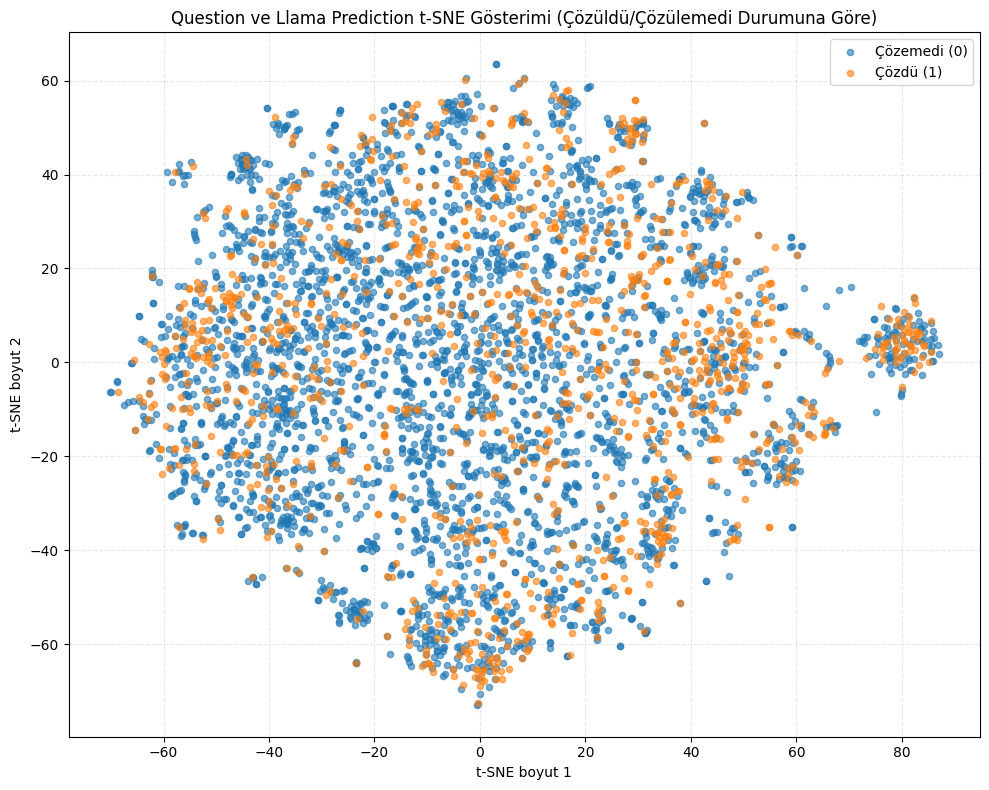

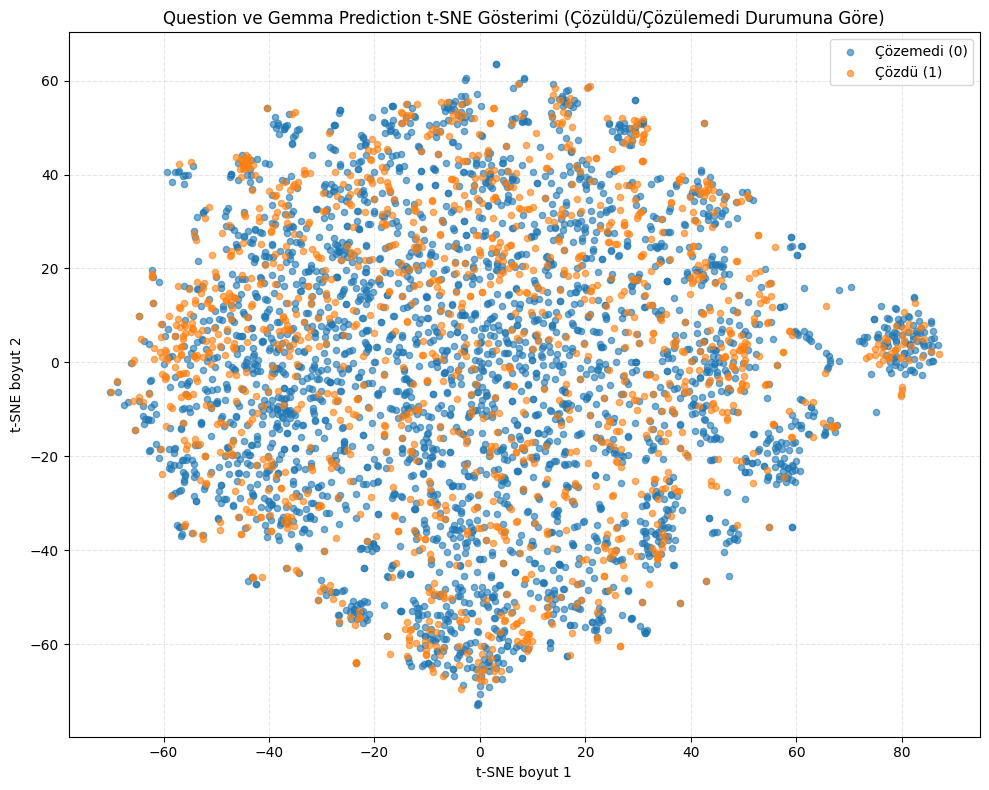

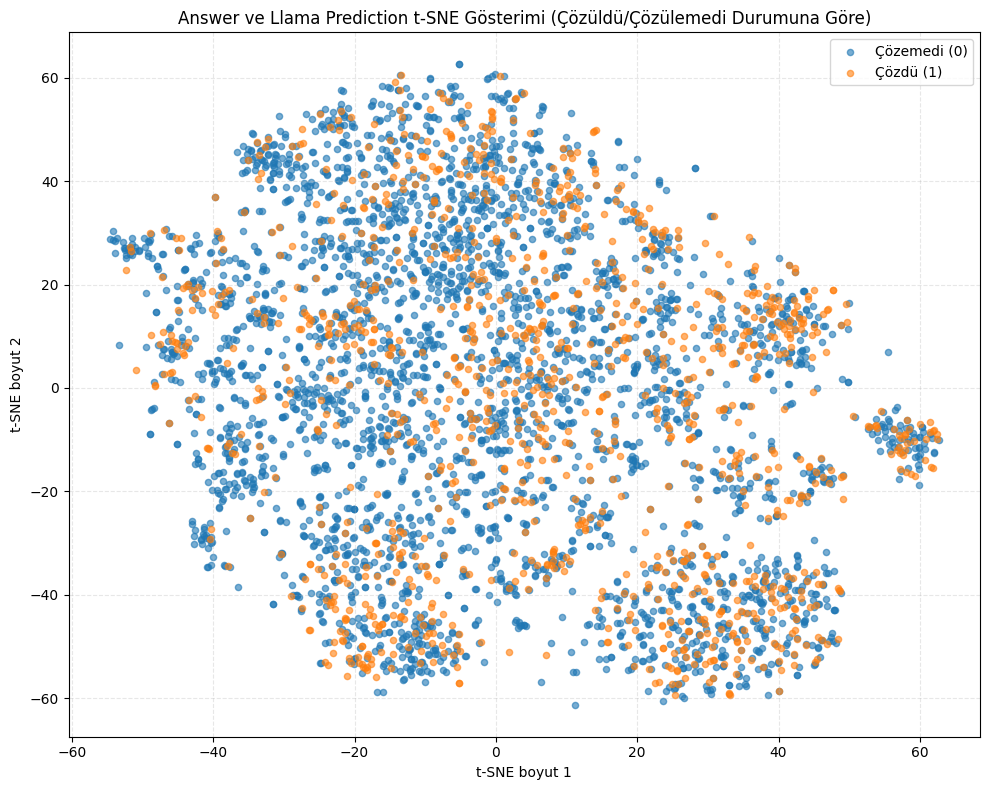

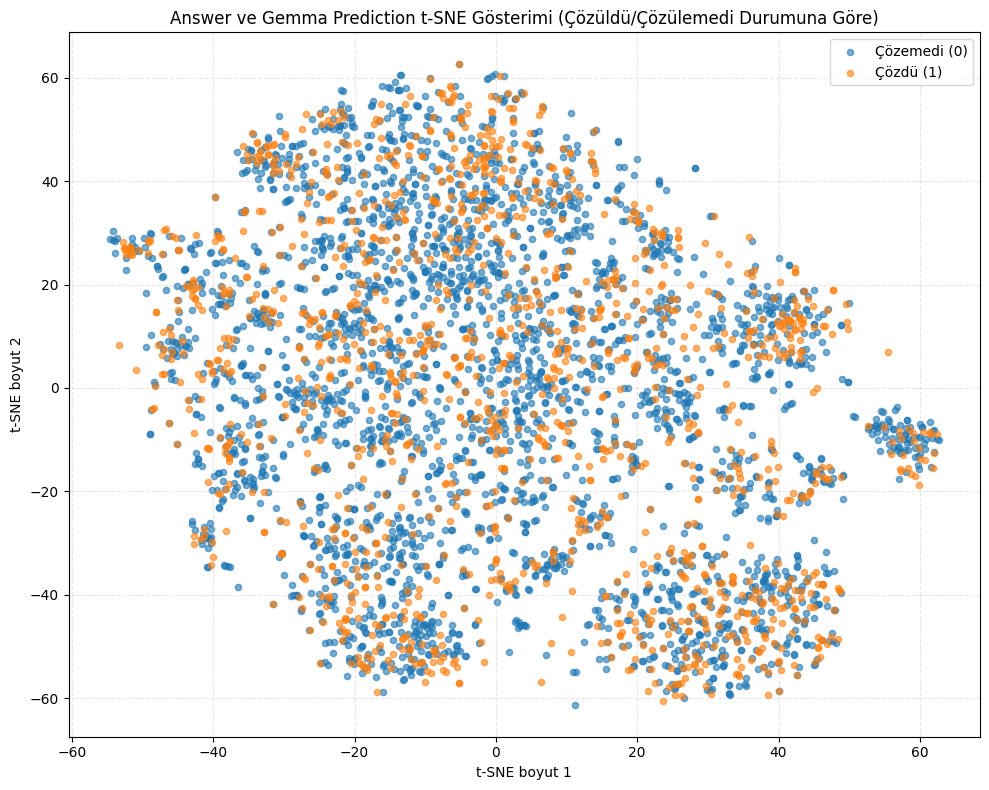

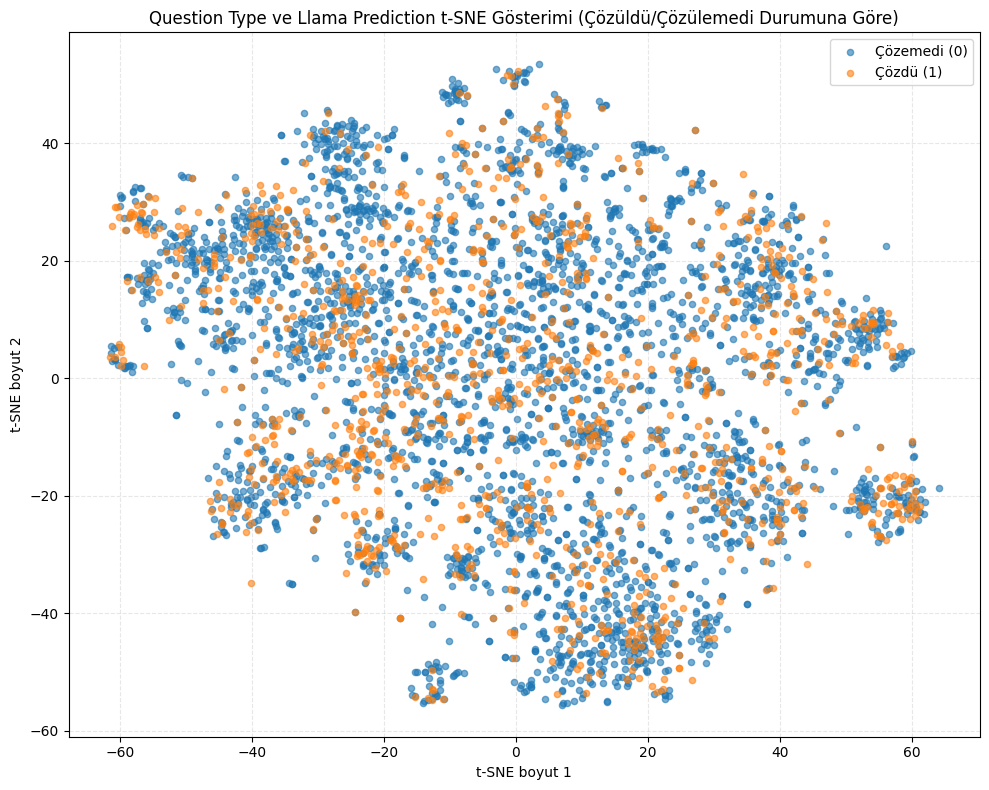

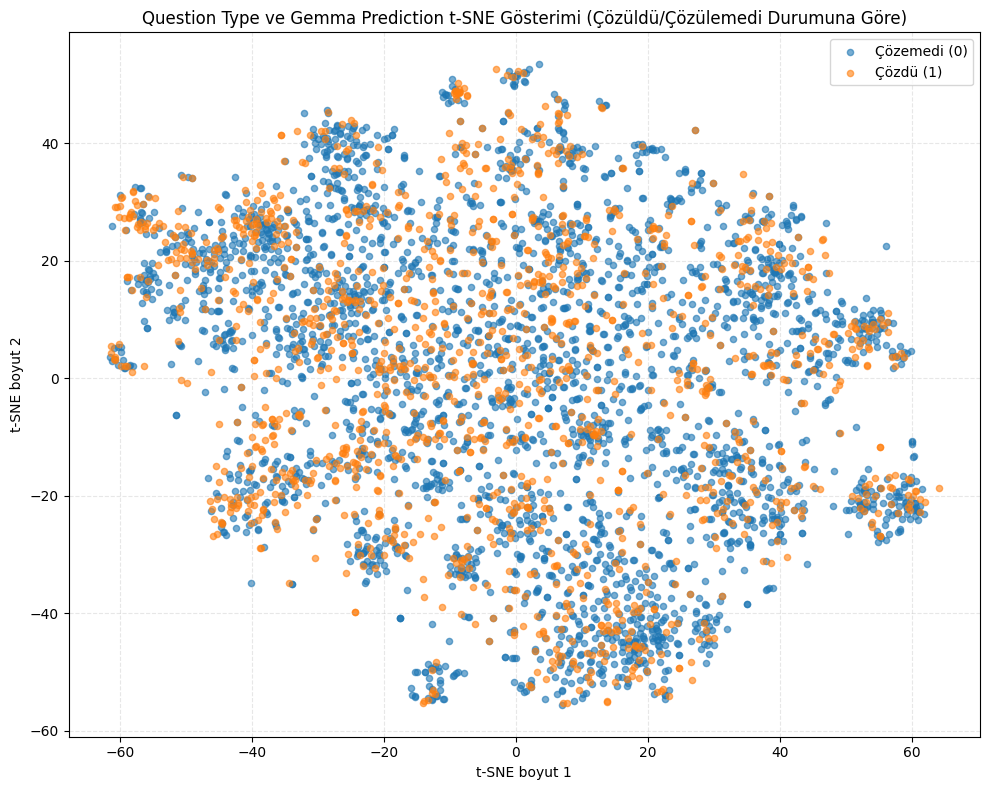

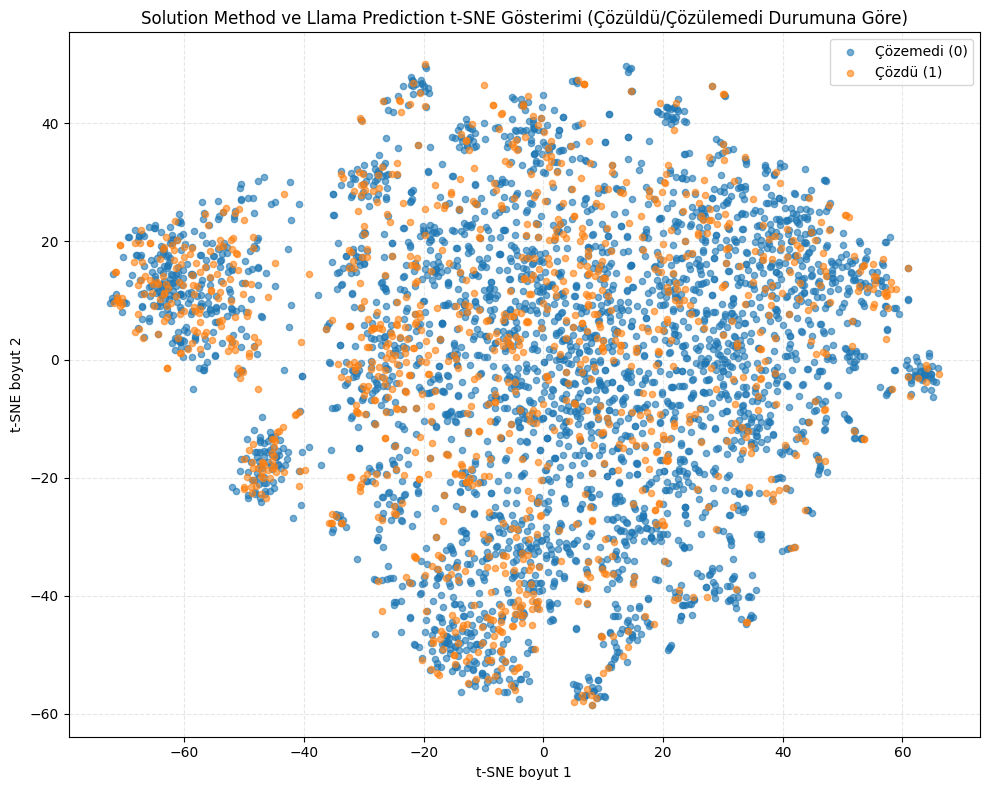

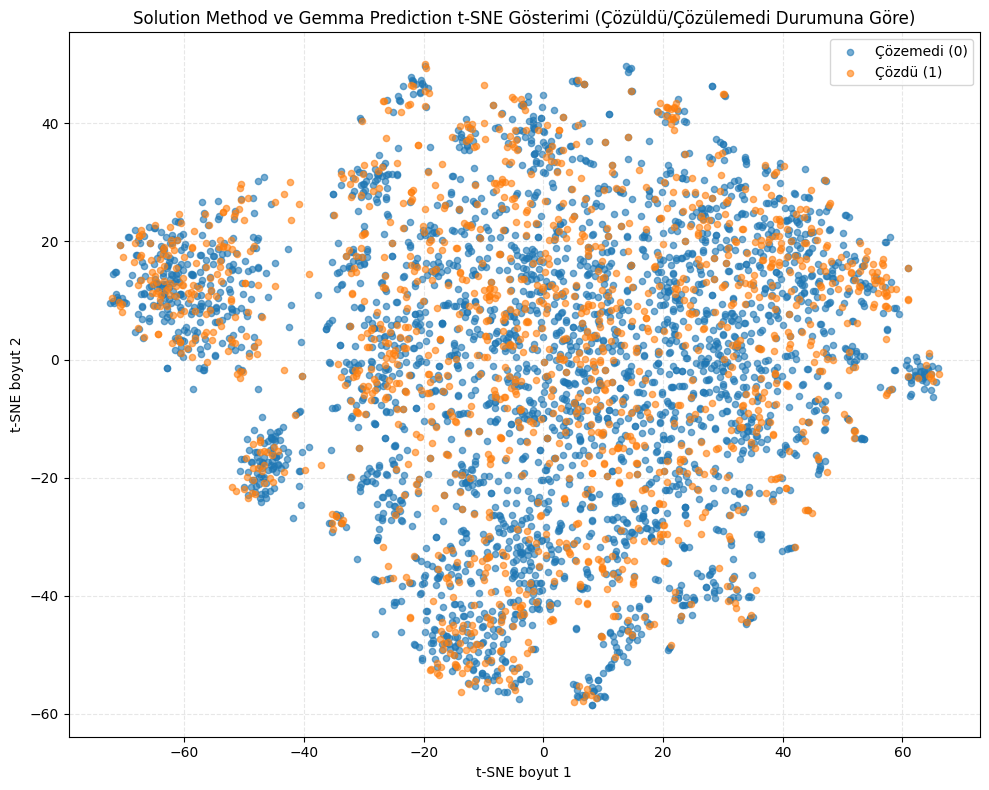

In [48]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Örnek:
# X = np.concatenate([Q, A, QT, SM], axis=1)
# y = y_test_llama    # veya y_test_gemma

# t-SNE ile 2 boyuta indirgeme
tsne = TSNE(
    n_components=2,
    perplexity=30,      # veri sayısına göre 5-50 arası değer
    learning_rate='auto',
    init='random',
    random_state=42,
    n_iter=1000
)

# X şu embedding'lerden oluşuyor:
# Q: Question, A: Answer, QT: Question Type, SM: Solutiıon Method

def plot_embedding(X, Y, title=None):
    X_2d = tsne.fit_transform(X)
    plt.figure(figsize=(10,8))

    # Llama sonuçları için renkler ve etiketler
    colors_llama = ['#1f77b4', '#ff7f0e'] # Mavi: Çözemedi, Turuncu: Çözdü
    labels_llama = ['Çözemedi (0)', 'Çözdü (1)']

    # Llama sonuçlarını çizme
    for class_val in np.unique(Y):
        idx = (Y == class_val)
        plt.scatter(
            X_2d[idx,0], X_2d[idx,1],
            c=colors_llama[int(class_val)],
            label=labels_llama[int(class_val)],
            alpha=0.6,
            s=20,
            marker='o' # Llama için daire
        )

    plt.legend()
    plt.title(title)
    plt.xlabel("t-SNE boyut 1") # Örnekler diyebiliriz
    plt.ylabel("t-SNE boyut 2") # Embedding değerleri
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_embedding(Q_test_llama, llama_q_pred, title="Question ve Llama Prediction t-SNE Gösterimi (Çözüldü/Çözülemedi Durumuna Göre)")
plot_embedding(Q_test_gemma, gemma_q_pred, title="Question ve Gemma Prediction t-SNE Gösterimi (Çözüldü/Çözülemedi Durumuna Göre)")

plot_embedding(A_test_llama, llama_q_pred, title="Answer ve Llama Prediction t-SNE Gösterimi (Çözüldü/Çözülemedi Durumuna Göre)")
plot_embedding(A_test_gemma, gemma_q_pred, title="Answer ve Gemma Prediction t-SNE Gösterimi (Çözüldü/Çözülemedi Durumuna Göre)")

plot_embedding(QT_test_llama, llama_q_pred, title="Question Type ve Llama Prediction t-SNE Gösterimi (Çözüldü/Çözülemedi Durumuna Göre)")
plot_embedding(QT_test_gemma, gemma_q_pred, title="Question Type ve Gemma Prediction t-SNE Gösterimi (Çözüldü/Çözülemedi Durumuna Göre)")

plot_embedding(SM_test_llama, llama_q_pred, title="Solution Method ve Llama Prediction t-SNE Gösterimi (Çözüldü/Çözülemedi Durumuna Göre)")
plot_embedding(SM_test_gemma, gemma_q_pred, title="Solution Method ve Gemma Prediction t-SNE Gösterimi (Çözüldü/Çözülemedi Durumuna Göre)")

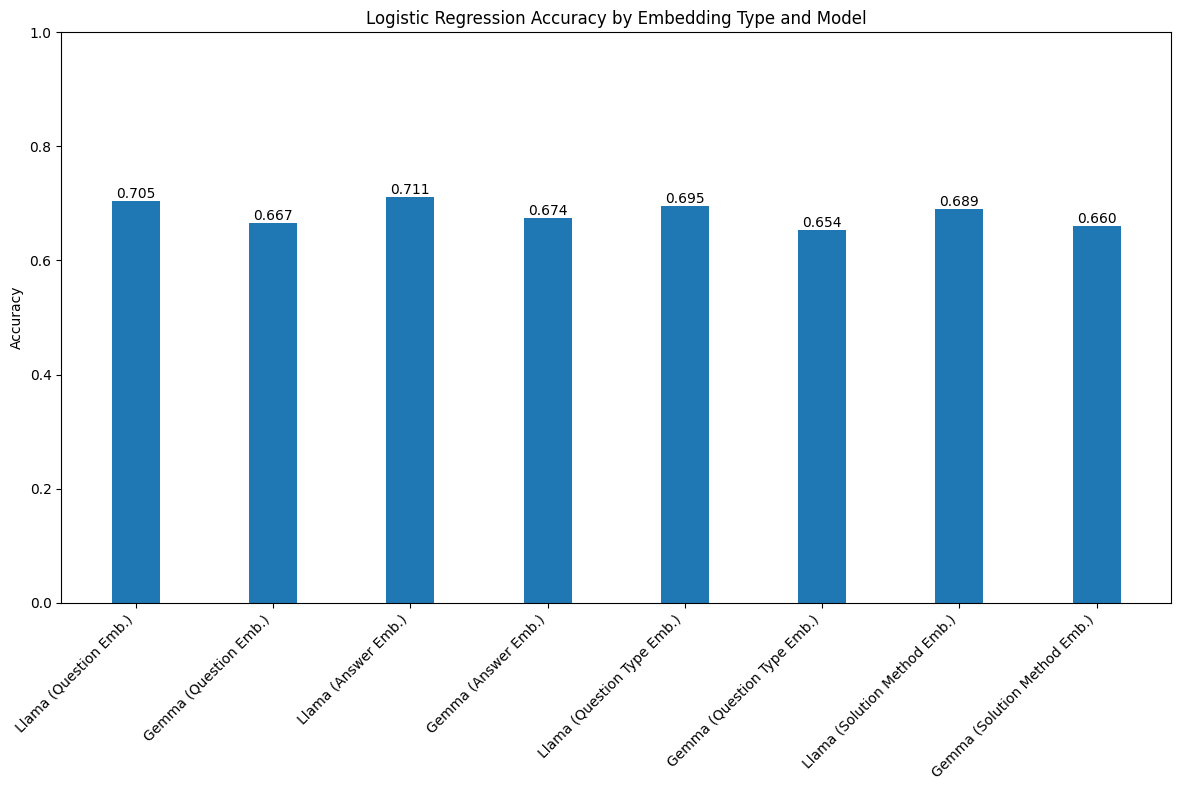

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracy değerlerini bir sözlükte saklayalım
accuracy_scores = {
    'Llama (Question Emb.)': llama_q_accuracy,
    'Gemma (Question Emb.)': gemma_q_accuracy,
    'Llama (Answer Emb.)': llama_a_accuracy,
    'Gemma (Answer Emb.)': gemma_a_accuracy,
    'Llama (Question Type Emb.)': llama_qt_accuracy,
    'Gemma (Question Type Emb.)': gemma_qt_accuracy,
    'Llama (Solution Method Emb.)': llama_sm_accuracy,
    'Gemma (Solution Method Emb.)': gemma_sm_accuracy,
}

labels = list(accuracy_scores.keys())
values = list(accuracy_scores.values())

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(x, values, width)

# Add some text for labels, title and axes ticks
ax.set_ylabel('Accuracy')
ax.set_title('Logistic Regression Accuracy by Embedding Type and Model')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_ylim([0, 1]) # Accuracy 0 ile 1 arasında değer alır

# Add the accuracy value on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.3f}', va='bottom', ha='center') # add value label on top

plt.tight_layout()
plt.show()